In [17]:
import pandas as pd
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from collections import Counter

In [ ]:
def load_participant_data(file_path):

        '''
        input: 
        A csv file from the DREAMT dataset
    
        return: a dataframes containing 4 sleep stages (W, N1, N2, R), no mising values and certain columns dropped with high null ratios
        '''

        df = pd.read_csv(file_path).drop(columns=['Obstructive_Apnea', 'Central_Apnea', 'Hypopnea', 'Multiple_Events'])

        df = df[df['Sleep_Stage'] != 'P']

        return df

In [66]:
df_S002 = load_participant_data('/Users/daviddechantsreiter/Desktop/WPI/Courses/Machine Learning/sleep-ml/physionet_data/S002_whole_df.csv')
df_S050 = load_participant_data('/Users/daviddechantsreiter/Desktop/WPI/Courses/Machine Learning/sleep-ml/physionet_data/S050_whole_df.csv')
df_S051 = load_participant_data('/Users/daviddechantsreiter/Desktop/WPI/Courses/Machine Learning/sleep-ml/physionet_data/S051_whole_df.csv')
df_S052 = load_participant_data('/Users/daviddechantsreiter/Desktop/WPI/Courses/Machine Learning/sleep-ml//physionet_data/S052_whole_df.csv')

In [67]:
counts2 = Counter(df_S002['Sleep_Stage'])
counts50 = Counter(df_S050['Sleep_Stage'])
counts51 = Counter(df_S051['Sleep_Stage'])
counts52 = Counter(df_S052['Sleep_Stage'])
print(counts2)
print(counts50)
print(counts51)
print(counts52)

Counter({'N2': 641280, 'W': 508801, 'R': 153600, 'N1': 122880})
Counter({'N2': 1107840, 'W': 161281, 'N1': 84480, 'R': 23040, 'N3': 5760})
Counter({'N2': 900480, 'W': 224641, 'R': 211200, 'N1': 138240})
Counter({'N2': 917760, 'W': 309120, 'N1': 159360, 'N3': 145920, 'R': 115201})


In [5]:
df_S002_big = load_participant_data('/Users/daviddechantsreiter/Desktop/WPI/Courses/Machine Learning/sleep-ml/physionet_data/S002_whole_df.csv')

df_S002_big

,TIMESTAMP,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,Sleep_Stage
587136,9174.000000,25.61,-22.0,-61.0,5.0,32.09,0.065320,72.85,1.062500,W
587137,9174.015625,23.45,-22.0,-61.0,5.0,32.09,0.065320,72.85,1.062500,W
587138,9174.031250,21.99,-22.0,-62.0,4.0,32.09,0.065320,72.85,1.062500,W
587139,9174.046875,21.14,-22.0,-62.0,4.0,32.09,0.065320,72.85,1.062500,W
587140,9174.062500,20.52,-19.0,-61.0,10.0,32.09,0.065320,72.85,1.062500,W
...,...,...,...,...,...,...,...,...,...,...
2013692,31463.937500,120.17,-33.0,-24.0,50.0,35.37,0.142168,78.13,1.046875,W
2013693,31463.953125,106.78,-33.0,-24.0,50.0,35.37,0.142168,78.13,1.046875,W
2013694,31463.968750,98.52,-33.0,-24.0,51.0,35.37,0.142168,78.13,1.046875,W
2013695,31463.984375,95.02,-33.0,-24.0,51.0,35.37,0.142168,78.13,1.046875,W


In [6]:


if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [7]:
# Constants
SAMPLE_RATE = 64  # Hz
SEGMENT_LENGTH = 30  # seconds
FEATURES = df_S002_big.columns[1:-1]  # Your physiological signals

# SleepStageDataset

In [8]:
# Create a custom Dataset
class SleepStageDataset():
    def __init__(self, dataframe, sample_rate=64, segment_seconds=30):
        self.df = dataframe
        self.sample_rate = sample_rate
        self.segment_seconds = segment_seconds
        self.samples_per_segment = sample_rate * segment_seconds
        self.segments = self.create_segments()
        
         # Create a mapping dictionary
        self.label_map = {
            'W': 0,   # Wake
            'N1': 1,  # NREM stage 1
            'N2': 2,  # NREM stage 2
            'N3': 3,  # NREM stage 3
            'R': 4    # REM
        }
        
    def create_segments(self):
        segments = []
        n_segments = len(self.df) // self.samples_per_segment
        
        for i in range(n_segments):
            start_idx = i * self.samples_per_segment
            end_idx = start_idx + self.samples_per_segment
            
            segment = self.df.iloc[start_idx:end_idx].copy()
            
            if len(segment) < self.samples_per_segment:
                continue
                
            # Get the most common sleep stage in this segment
            sleep_stage_column = 'Sleep_Stage'  # Adjust to match your actual column name
            if sleep_stage_column in segment.columns:
                label = segment[sleep_stage_column].mode()[0]
                
                # Create feature array
                features = np.zeros((len(FEATURES), self.samples_per_segment))
                for j, feature in enumerate(FEATURES):
                    if feature in segment.columns:
                        features[j, :] = segment[feature].values
                
                segments.append((features, label))
        
        return segments
    
    def __len__(self):
        return len(self.segments)

    # Function to convert string labels to integers
    def convert_labels(string_labels):
        return [label_map[label] for label in string_labels]

    def __getitem__(self, idx):
        features, label = self.segments[idx]
        features_tensor = torch.tensor(features, dtype=torch.float).unsqueeze(0)
    
        # Convert string label to integer
        label_idx = torch.tensor(self.label_map[label], dtype=torch.long)
    
        return features_tensor, label_idx

# SleepStageCNN

In [9]:
# Define the CNN model
class SleepStageCNN(nn.Module):
    def __init__(self, num_classes):
        super(SleepStageCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        # Calculate the size after convolutions and pooling
        # This depends on your input size and may need adjustment
        flattened_size = self._get_conv_output_size()
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def _get_conv_output_size(self):
        # This helper function calculates the size of the flattened features
        # after the convolutional layers
        # You need to adjust the input size based on your data
        dummy_input = torch.zeros(1, 1, len(FEATURES), SAMPLE_RATE * SEGMENT_LENGTH)
        output = self.conv_layers(dummy_input)
        return output.numel() // output.shape[0]
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Train Function

In [10]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    
    return model

# Training

In [11]:
# Assuming your_dataframe is your pandas DataFrame with all required columns
    
# Create datasets and dataloaders
dataset = SleepStageDataset(df_S002_big)
    
# Split into train and validation sets
# For proper cross-validation, split by participants
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
# Initialize and train the model
num_classes = 5  # Adjust based on your sleep stage categories
model = SleepStageCNN(num_classes)
    
trained_model = train_model(model, train_loader, val_loader)
    
# Save the model
torch.save(trained_model.state_dict(), 'sleep_stage_model.pth')

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 1/10:
Train Loss: 8.0082, Val Loss: 1.1351, Val Accuracy: 0.5436
Epoch 2/10:
Train Loss: 1.0544, Val Loss: 1.0528, Val Accuracy: 0.5705
Epoch 3/10:
Train Loss: 0.9339, Val Loss: 1.2632, Val Accuracy: 0.5369
Epoch 4/10:
Train Loss: 0.9167, Val Loss: 1.0166, Val Accuracy: 0.6040
Epoch 5/10:
Train Loss: 0.8391, Val Loss: 1.3404, Val Accuracy: 0.6376
Epoch 6/10:
Train Loss: 0.6646, Val Loss: 1.1378, Val Accuracy: 0.6242
Epoch 7/10:
Train Loss: 0.5597, Val Loss: 1.0737, Val Accuracy: 0.6107
Epoch 8/10:
Train Loss: 0.5229, Val Loss: 1.1282, Val Accuracy: 0.6242
Epoch 9/10:
Train Loss: 0.4892, Val Loss: 1.1393, Val Accuracy: 0.6644
Epoch 10/10:
Train Loss: 0.4269, Val Loss: 1.2938, Val Accuracy: 0.6711


# Evaluation

In [12]:
def evaluate_model(model, data_loader, device, num_classes):
    model.eval()
    
    # Initialize lists to store true and predicted labels
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Collect the results
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate F1 scores
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Print classification report
    report = classification_report(y_true, y_pred)
    
    # Return all metrics
    results = {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    return results

def plot_confusion_matrix(cm, class_names=None):
    """
    Plot confusion matrix with seaborn and matplotlib
    """
    plt.figure(figsize=(10, 8))
    
    # Create a readable confusion matrix plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Example usage:
def evaluate_and_visualize(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Assuming you have these class names - replace with your actual sleep stage classes
    class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']
    num_classes = len(class_names)
    
    # Get evaluation metrics
    results = evaluate_model(model, val_loader, device, num_classes)
    
    # Print F1 scores
    print(f"F1 Score (Micro): {results['f1_micro']:.4f}")
    print(f"F1 Score (Macro): {results['f1_macro']:.4f}")
    print(f"F1 Score (Weighted): {results['f1_weighted']:.4f}")
    
    print("\nF1 Score per class:")
    for i, score in enumerate(results['f1_per_class']):
        print(f"  {class_names[i]}: {score:.4f}")
    
    print("\nClassification Report:")
    print(results['classification_report'])
    
    # Plot confusion matrix
    plot_confusion_matrix(results['confusion_matrix'], class_names)
    
    return results

F1 Score (Micro): 0.6711
F1 Score (Macro): 0.4822
F1 Score (Weighted): 0.6417

F1 Score per class:
  Wake: 0.6772
  N1: 0.0000
  N2: 0.8000
  N3: 0.4516

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.72      0.68        60
           1       0.00      0.00      0.00        12
           2       0.75      0.86      0.80        58
           4       0.58      0.37      0.45        19

    accuracy                           0.67       149
   macro avg       0.49      0.49      0.48       149
weighted avg       0.62      0.67      0.64       149



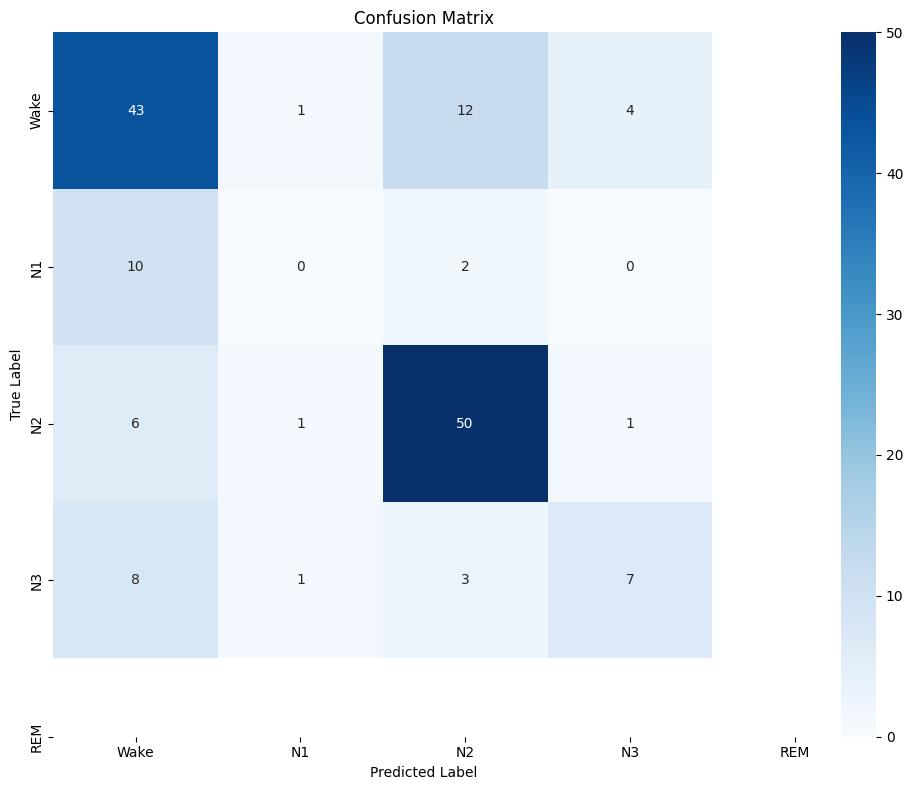

In [15]:
# Evaluate on validation set
eval_results = evaluate_and_visualize(trained_model, val_loader)

# Experimental

In [58]:
# Assuming your_dataframe is your pandas DataFrame with all required columns
r_count = 0
# Create datasets and dataloaders
dataset = SleepStageDataset(df_S002_big)

for array, l in dataset.segments:
    if l == 'R':
        r_count+=1
        
print(r_count)

80


In [ ]:
df_S002_big[1920*180:1920*181]
counts = Counter(df_S002_big['Sleep_Stage'])

print(counts)

In [41]:
dataset = SleepStageDataset(df_S002_big)

In [44]:
dataset.segments[1]

(array([[ 1.07690e+02,  1.13910e+02,  1.21750e+02, ...,  4.85800e+01,
          4.66700e+01,  4.37200e+01],
        [-1.60000e+01, -1.60000e+01, -1.70000e+01, ..., -1.90000e+01,
         -1.90000e+01, -1.90000e+01],
        [-6.30000e+01, -6.30000e+01, -6.30000e+01, ..., -6.20000e+01,
         -6.20000e+01, -6.20000e+01],
        ...,
        [ 6.53200e-02,  6.53200e-02,  6.53200e-02, ...,  6.53200e-02,
          6.53200e-02,  6.53200e-02],
        [ 8.09800e+01,  8.09800e+01,  8.09800e+01, ...,  8.37200e+01,
          8.37200e+01,  8.37200e+01],
        [ 9.53125e-01,  9.53125e-01,  9.53125e-01, ...,  9.53125e-01,
          9.53125e-01,  9.53125e-01]]),
 'W')

In [45]:
print(torch.cuda.is_available())  # Should print True if GPU is available
print(torch.cuda.device_count())  # Number of GPUs available

False
0


In [ ]:
#images, np.array(labels) = create_signal_images(df_S002_big)